In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

## 生成数据集

In [12]:
def synthetic_data(w, b, num_examples):  #@save
    """生成 y = Xw + b + 噪声。"""
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
#     print(y.shape)
    y += torch.normal(0, 0.01, y.shape) #torch.normal(means, std, out=None)
#     print(X)
#     print(y)
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [13]:
print('features:', features[0], '\nlabel:', labels[0])

features: tensor([-0.0487, -0.1451]) 
label: tensor([4.5993])


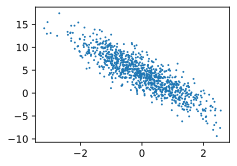

In [22]:
#features[:, (1)] # 取第二维度
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(),
                labels.detach().numpy(), 1);

## 读取数据集

In [23]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i +
                                                   batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [29]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.0499, -1.2834],
        [ 0.1727,  0.3146],
        [-0.1988, -0.6015],
        [ 0.0176,  0.7264],
        [-0.1988,  0.4095],
        [ 0.2702,  2.3925],
        [ 0.3474, -0.5325],
        [ 0.0687, -0.0537],
        [ 0.9314, -0.0979],
        [ 1.2617,  0.5954]]) 
 tensor([[ 8.6556],
        [ 3.4861],
        [ 5.8371],
        [ 1.7677],
        [ 2.4159],
        [-3.3940],
        [ 6.7136],
        [ 4.5138],
        [ 6.3869],
        [ 4.6809]])


## 初始化模型参数
我们通过从均值为0、标准差为0.01的正态分布中采样随机数来初始化权重，并将偏置初始化为0。

In [30]:
w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [31]:
w, b

(tensor([[-0.0067],
         [ 0.0152]], requires_grad=True),
 tensor([0.], requires_grad=True))

## 定义模型

In [33]:
def linreg(X, w, b):  #@save
    """线性回归模型。"""
    return torch.matmul(X, w) + b

## 定义损失函数
我们需要将真实值y的形状转换为和预测值y_hat的形状相同

In [34]:
def squared_loss(y_hat, y):  #@save
    """均方损失。"""
    return (y_hat - y.reshape(y_hat.shape))**2 / 2

## 定义优化算法

In [35]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降。"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

## 训练
在整个深度学习的职业生涯中，你会看到一遍又一遍几乎相同的训练过程。


在每次迭代中，我们读取一小批量训练样本，并通过我们的模型来获得一组预测。 计算完损失后，我们开始反向传播，存储每个参数的梯度。最后，我们调用优化算法 sgd 来更新模型参数。

In [36]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  # `X`和`y`的小批量损失
        # 因为`l`形状是(`batch_size`, 1)，而不是一个标量。`l`中的所有元素被加到一起，
        # 并以此计算关于[`w`, `b`]的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.032776
epoch 2, loss 0.000118
epoch 3, loss 0.000052


通过比较真实参数和通过训练学到的参数来评估训练的成功程度

In [37]:
true_w, true_b, w, b

(tensor([ 2.0000, -3.4000]),
 4.2,
 tensor([[ 1.9993],
         [-3.3996]], requires_grad=True),
 tensor([4.1997], requires_grad=True))

In [38]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([ 0.0007, -0.0004], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0003], grad_fn=<RsubBackward1>)
